In [ ]:
%cd /content/drive/MyDrive/sign_data

/content/drive/.shortcut-targets-by-id/1hFljH9AKhxxIqH-3fj72mCMA6Xh3Vv0m/sign_data


In [ ]:
#%%
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from skimage import io
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision import utils
from PIL import Image

# Load dataset
train_dir = "/content/drive/MyDrive/sign_data/train"
test_dir = "/content/drive/MyDrive/sign_data/test"
train_csv = "./train_data.csv"
test_csv = "./test_data.csv"

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1.0)),
                                transforms.ToTensor()])


#dataset creation
class SiameseData(torch.utils.data.Dataset):
    def __init__(self, train_csv=None, train_dir=None, transform=None):
        self.train_df = pd.read_csv(train_csv)
        self.train_df.columns = ['image1', 'image2', 'image3']
        self.train_dir = train_dir
        self.transform = transform

    def __getitem__(self, index): #take random indexes, imaage pairs & annotations are taken
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])
        img1 = Image.open(image1_path)
        img2 = Image.open(image2_path)
        img1 = img1.convert("L")
        img2 = img2.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([int(self.train_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.train_df)

train_ds = SiameseData(train_csv, train_dir, transform=transform)
test_ds = SiameseData(test_csv, test_dir, transform=transform)

train_dataloader = DataLoader(train_ds, shuffle=True, num_workers=2, pin_memory=True, batch_size=32)
eval_dataloader = DataLoader(test_ds, shuffle=False, num_workers=2, pin_memory=True, batch_size=32)

In [ ]:
test_csv

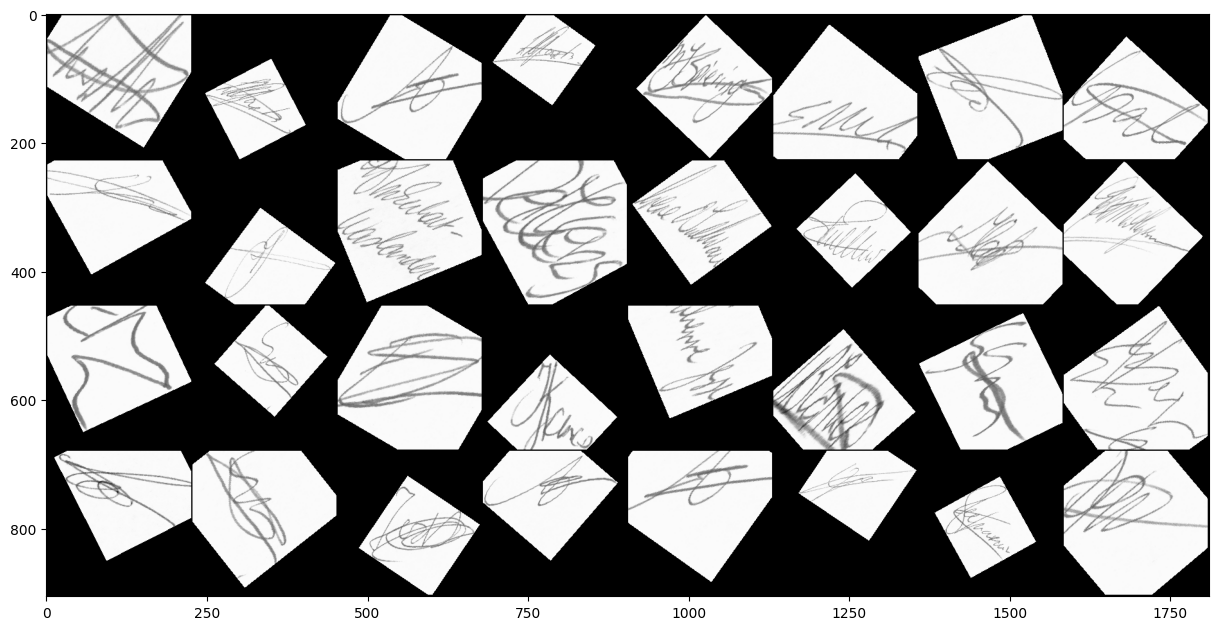

In [ ]:
#%%
# visualize data
import matplotlib.pyplot as plt

# Get a batch of training data
images, _, labels = next(iter(train_dataloader))

# Make a grid from batch
grid = utils.make_grid(images)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

plt.show()

# model

In [ ]:
class ContrastiveLoss(nn.Module):
    "Contrastive loss function"
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2,keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
from torch import nn

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.GELU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.GELU(),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.GELU(),

            nn.Conv2d(384, 768, kernel_size=3, stride=1, padding=1),
            nn.GELU(),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),
        )

        # Adding AvgPooling before the fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(768, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.GELU(),

            nn.Linear(128, 2)
        )

    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = self.avgpool(output)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # Forward pass of input 1
        output1 = self.forward_once(input1)
        # Forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [ ]:
efficientnet_v2_s()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
from torchvision.models import efficientnet_v2_s
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = efficientnet_v2_s(weights="DEFAULT")
        self.feature_extractor.features[0][0] = nn.Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.feature_extractor.classifier = nn.Identity()
        self.embedding = nn.Sequential(
            nn.Linear(1280, 2),
            # nn.GELU(),
            # nn.Linear(128, 2)
        )

    def forward(self, x1, x2):
        output1 = self.feature_extractor(x1)
        output2 = self.feature_extractor(x2)

        output1 = output1.view(output1.size()[0], -1)
        output2 = output2.view(output2.size()[0], -1)

        output1 = self.embedding(output1)
        output2 = self.embedding(output2)

        return output1, output2


# Train

In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
epochs = 10

In [ ]:
#train the model
def train(train_dataloader):
    loss=[]
    counter=[]
    iteration_number = 0
    for i, data in enumerate(train_dataloader,0):
      img0, img1 , label = data
      img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
      optimizer.zero_grad()
      output1,output2 = net(img0,img1)
      loss_contrastive = criterion(output1,output2,label)
      loss_contrastive.backward()
      optimizer.step()
      loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(train_dataloader)


def eval(eval_dataloader):
    loss = []
    counter = []
    iteration_number = 0

    net.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation during evaluation
        for i, data in enumerate(eval_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss.append(loss_contrastive.item())

    loss = np.array(loss)
    net.train()  # Set the model back to training mode
    return loss.mean() / len(eval_dataloader)


for epoch in range(1, epochs):
    best_eval_loss = 9999
    train_loss = train(train_dataloader)
    eval_loss = eval(eval_dataloader)

    print(f"Training loss: {train_loss}")
    print("-" * 20)
    print(f"Evaluation loss: {eval_loss}")

    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        print("-" * 20)
        print(f"Best Eval loss: {best_eval_loss}")
        torch.save(net.state_dict(), '/content/model.pt')
        print("Model Saved Successfully")


Training loss: 0.000923895366542373
--------------------
Evaluation loss: 0.0021355630460132007
--------------------
Best Eval loss: 0.0021355630460132007
Model Saved Successfully
Training loss: 0.000203008910947186
--------------------
Evaluation loss: 0.00025593989422002263
--------------------
Best Eval loss: 0.00025593989422002263
Model Saved Successfully
Training loss: 0.00022443331199910533
--------------------
Evaluation loss: 0.0010239811731145982
--------------------
Best Eval loss: 0.0010239811731145982
Model Saved Successfully
Training loss: 0.00018097162192007833
--------------------
Evaluation loss: 0.0028266293705257093
--------------------
Best Eval loss: 0.0028266293705257093
Model Saved Successfully
Training loss: 0.00017283020140167063
--------------------
Evaluation loss: 0.003207032178715626
--------------------
Best Eval loss: 0.003207032178715626
Model Saved Successfully
Training loss: 0.00012164519064412458
--------------------
Evaluation loss: 0.0023472211106944

In [ ]:
torch.save(net.state_dict(), '/content/model.pt')

In [ ]:
net = SiameseNetwork()
net.load_state_dict(torch.load("/content/drive/MyDrive/sign_data/model.pt",map_location=torch.device('cpu')))

In [ ]:
# Load the test dataset
test_dataset = SiameseDataset(
    training_csv=testing_csv,
    training_dir=testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

count = 0
for i, data in enumerate(test_dataloader, 0):
    x0, x1, label = data
    concat = torch.cat((x0, x1), 0)
    output1, output2 = model(x0.to(device), x1.to(device))

    eucledian_distance = F.pairwise_distance(output1, output2)

    if label == torch.FloatTensor([[0]]):
        label = "Original Pair Of Signature"
    else:
        label = "Forged Pair Of Signature"

    imshow(torchvision.utils.make_grid(concat))
    print("Predicted Eucledian Distance:-", eucledian_distance.item())
    print("Actual Label:-", label)
    count = count + 1
    if count == 10:
        break